# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [5]:
# Import essential libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
import zipfile
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import callbacks
from PIL import Image as im
from collections import defaultdict

!ls -lh /content/data.zip

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import os

-rw-r--r-- 1 root root 478M Apr 16 12:39 /content/data.zip


Load the dataset.

In [3]:
# Load and unzip the dataset

# Unzip the file
with zipfile.ZipFile("/content/data.zip", 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("Dataset extracted successfully to '/data'")


Dataset extracted successfully to '/data'


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images

def load_raw_images(data_dir):
    """
    Loads raw images and their labels from the given directory.

    Arguments:
        data_dir(str): Path to the dataset directory.

    Returns:
        images(list): List of raw image arrays.
        labels(list): List of corresponding class labels.
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = im.open(img_path).convert('RGB')
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
            except Exception as err:
                print(f"Error loading image: {img_path}, Reason: {err}")

    return images, labels

def count_images_per_class(data_dir):
    """
    Counts and prints number of images in each subdirectory (label/class).

    Args:
        data_dir (str): Path to dataset directory.
    """
    class_counts = {}

    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            class_counts[class_name] = image_count

    return class_counts

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Get the images and their labels

data_path = '/content/data'
images, labels = load_raw_images(data_path)

print(f"Total images loaded: {len(images)}")
print(f"Unique labels found: {set(labels)}")

class_counts = count_images_per_class(data_path)
print("Image count per class:\n")
for label, count in class_counts.items():
    print(f"{label:15s} : {count}")

Total images loaded: 7625
Unique labels found: {'Glass', 'Other', 'Paper', 'Cardboard', 'Food_Waste', 'Metal', 'Plastic'}
Image count per class:

Cardboard       : 540
Food_Waste      : 1000
Glass           : 750
Metal           : 1000
Other           : 1010
Paper           : 1030
Plastic         : 2295


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

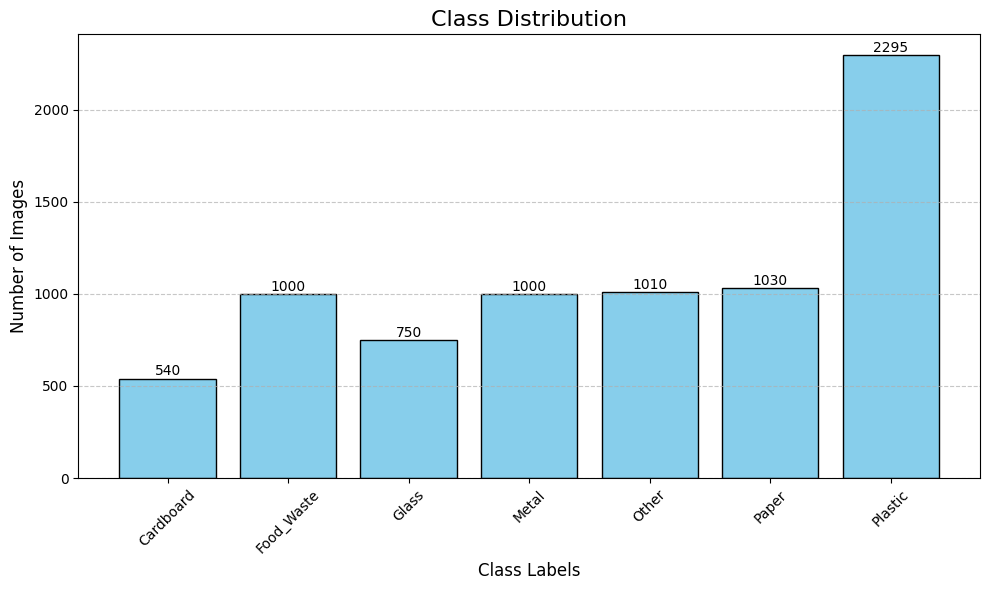

In [ ]:
# Visualise Data Distribution

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='skyblue', edgecolor='black')

plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add counts above the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
          ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

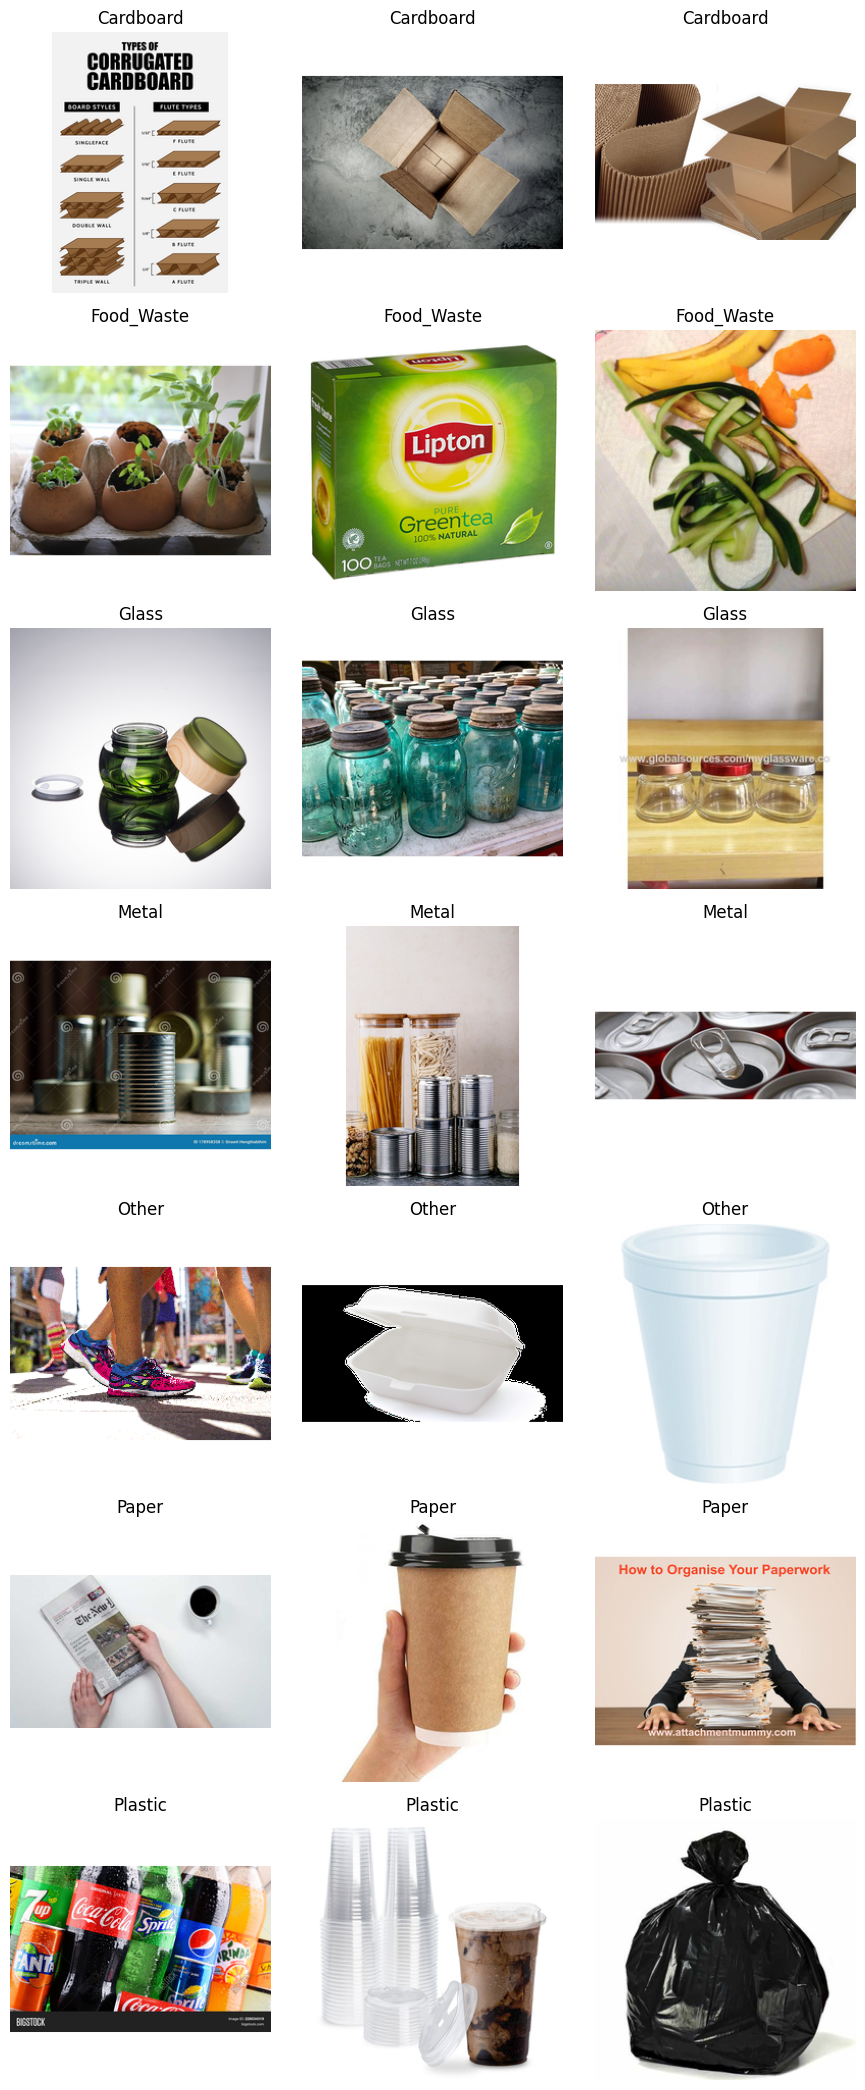

In [ ]:
# Visualise Sample Images (across different labels)

label_to_images = defaultdict(list)

for img, label in zip(images, labels):
    if len(label_to_images[label]) < 3:
        label_to_images[label].append(img)

class_names = sorted(label_to_images.keys())
num_classes = len(class_names)


plt.figure(figsize=(9, 21))

plot_index = 1
for class_name in class_names:
    for i in range(len(label_to_images[class_name])):
        plt.subplot(num_classes, 3, plot_index)
        plt.imshow(label_to_images[class_name][i])
        plt.title(f"{class_name}")
        plt.axis('off')
        plot_index += 1

plt.tight_layout()
plt.show()



#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set

# Get image sizes from the PIL Image objects
image_sizes = [img.size for img in images]  # Each is (width, height)

# Find min and max by area (width * height), or by width/height separately
smallest_image = min(image_sizes, key=lambda x: x[0] * x[1])
largest_image = max(image_sizes, key=lambda x: x[0] * x[1])

print(f"Smallest image dimensions (W x H): {smallest_image}")
print(f"Largest image dimensions  (W x H): {largest_image}")

Smallest image dimensions (W x H): (256, 256)
Largest image dimensions  (W x H): (256, 256)


In [ ]:
# Resize the image dimensions
'''
It's not required to resize these images because of the following reasons:-
1. Big enough to retain important features.
2. Not too large — won’t slow training excessively.
3. Well-supported by standard CNN architectures (ResNet, VGG, MobileNet, etc.).

We might resize images only if:
1. We decide to use a pretrained model that requires a specific input size (like 224x224 for ResNet).
2. We decide to speed up training by using smaller images like 128x128 (but this might reduce accuracy).
'''
# Now after tring to train in google colab, the process is taking too long and not completing.
# So the images are being resized to a smaller size.

# Choose target size (you can adjust it based on your needs)
target_size = (128, 128)  # (width, height)

# Resize all images to target_size
resized_images = [img.resize(target_size, im.Resampling.LANCZOS) for img in images]

print(f"All images resized to: {target_size}")

All images resized to: (128, 128)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably
# Step 1: Create the encoder
label_encoder = LabelEncoder()

# Step 2: Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

# Check results
print(f"Original labels: {labels[:]}")
print(f"Encoded labels: {encoded_labels[:]}")
print(f"Classes: {label_encoder.classes_}")


Original labels: ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardbo

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# Assign specified parts of the dataset to train and validation sets
'''
# Split the data: 70% training, 30% validation
X_train, X_val, y_train, y_val = train_test_split(
    images, encoded_labels,
    test_size=0.3,
    stratify=encoded_labels,  # ensures class distribution is preserved
    random_state=42
)

# Confirm the splits
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Convert X_train and X_val (PIL images) into NumPy arrays and normalize
X_train = np.array([np.array(img) / 255.0 for img in X_train], dtype=np.float32)
X_val = np.array([np.array(img) / 255.0 for img in X_val], dtype=np.float32)

# Convert y_train and y_val to NumPy arrays if they aren't already
y_train = np.array(y_train)
y_val = np.array(y_val)

# Optional: print shape
print("X_train shape:", X_train.shape)  # Should be (num_samples, 256, 256, 3)
print("y_train shape:", y_train.shape)
'''
# Above code is failing in google colab due to less memory available so we will use ImageDataGenerator as it loads
# images batch by batch

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths
data_dir = "/content/data"

# Create generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 5338 images belonging to 7 classes.
Found 2287 images belonging to 7 classes.


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# Build and compile the model
####################### MODEL Number 1 #####################################
# Number of output classes
num_classes = 7

model = models.Sequential([
    # 1st Conv Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # 2nd Conv Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 3rd Conv Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # use this for integer labels
    metrics=['accuracy']
)

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,951 (12.62 MB)

 Trainable params: 3,306,247 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.


Use appropriate metrics and callbacks as needed.

In [ ]:

################ Training MODEL Numnber 1 ###############################

# Define callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, model_checkpoint, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2687 - loss: 2.4120
Epoch 1: val_accuracy improved from -inf to 0.29952, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step - accuracy: 0.2690 - loss: 2.4104 - val_accuracy: 0.2995 - val_loss: 2.4821 - learning_rate: 0.0010
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4019 - loss: 1.7598
Epoch 2: val_accuracy did not improve from 0.29952
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.4019 - loss: 1.7595 - val_accuracy: 0.2746 - val_loss: 2.0451 - learning_rate: 0.0010
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4827 - loss: 1.4596
Epoch 3: val_accuracy did not improve from 0.29952
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.4827 - loss: 1.4596 - val_accuracy: 0.1810 - val_loss: 3.5397 - learning_rate: 0.0010
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5293 - loss: 1.3390
Epoch 4: val_accuracy improved from 0.29952 to 0.46393, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.5293 - loss: 1.3387 - val_accuracy: 0.4639 - val_loss: 1.5193 - learning_rate: 0.0010
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6001 - loss: 1.1546
Epoch 5: val_accuracy did not improve from 0.46393
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.6001 - loss: 1.1547 - val_accuracy: 0.4211 - val_loss: 1.9355 - learning_rate: 0.0010
Epoch 6/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6405 - loss: 1.0133
Epoch 6: val_accuracy did not improve from 0.46393
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.6405 - loss: 1.0134 - val_accuracy: 0.3507 - val_loss: 2.2798 - learning_rate: 0.0010
Epoch 7/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6389 - loss: 1.0179
Epoch 7: val_accuracy did not improve from 0.46393

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.6389 - loss: 1.0180

167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.7211 - loss: 0.8134 - val_accuracy: 0.5374 - val_loss: 1.3875 - learning_rate: 5.0000e-04
Epoch 9/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7791 - loss: 0.6471
Epoch 9: val_accuracy did not improve from 0.53739
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.7791 - loss: 0.6472 - val_accuracy: 0.4469 - val_loss: 1.8232 - learning_rate: 5.0000e-04
Epoch 10/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8054 - loss: 0.6020
Epoch 10: val_accuracy did not improve from 0.53739
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.8054 - loss: 0.6020 - val_accuracy: 0.4381 - val_loss: 1.9487 - learning_rate: 5.0000e-04
Epoch 11/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8178 - loss: 0.5534
Epoch 11: val_accuracy improved from 0.53739 to 0.54613, saving model to best_model.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.8178 - loss: 0.5534 - val_accuracy: 0.5461 - val_loss: 1.4897 - learning_rate: 5.0000e-04
Epoch 12/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8631 - loss: 0.4219
Epoch 12: val_accuracy improved from 0.54613 to 0.55531, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.8631 - loss: 0.4218 - val_accuracy: 0.5553 - val_loss: 1.4494 - learning_rate: 2.5000e-04
Epoch 13/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9050 - loss: 0.3201
Epoch 13: val_accuracy improved from 0.55531 to 0.55662, saving model to best_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9050 - loss: 0.3202 - val_accuracy: 0.5566 - val_loss: 1.4664 - learning_rate: 2.5000e-04
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


In [6]:
####################################  MODEL Number 2 #####################################

#################################### ResNet 18  ###########################################
'''
The reason to chose this is because it can work well with small dataSet and can work even without GPU.
I am using google colab free version and most of the time i do not get GPU but get only CPU.
Also, the results from above model are not good, so lets try a pretrained network and do some daat augmentation
as well.
'''

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the full dataset from /content/data
dataset_path = '/content/data'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Class names (in order)
class_names = full_dataset.classes
print("Classes:", class_names)

# Split into training and validation sets (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pretrained ResNet-18 and modify final layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # 7 waste categories
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"[{epoch+1}/{num_epochs}] Loss: {running_loss:.4f} | Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Validation Acc: {val_acc:.2f}%\n")

Using device: cpu
Classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


[1/10] Loss: 137.8257 | Train Acc: 75.11%
Validation Acc: 83.34%

[2/10] Loss: 63.4280 | Train Acc: 88.80%
Validation Acc: 86.03%

[3/10] Loss: 38.9479 | Train Acc: 93.36%
Validation Acc: 87.08%

[4/10] Loss: 25.4736 | Train Acc: 95.69%
Validation Acc: 87.21%

[5/10] Loss: 18.5971 | Train Acc: 97.13%
Validation Acc: 86.89%

[6/10] Loss: 17.2521 | Train Acc: 96.93%
Validation Acc: 86.89%

[7/10] Loss: 12.5406 | Train Acc: 98.07%
Validation Acc: 87.74%

[8/10] Loss: 11.4237 | Train Acc: 98.16%
Validation Acc: 88.33%

[9/10] Loss: 9.4182 | Train Acc: 98.43%
Validation Acc: 87.21%

[10/10] Loss: 9.0024 | Train Acc: 98.75%
Validation Acc: 86.89%



### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.5605 - loss: 1.4762

Validation Loss: 1.4664
Validation Accuracy: 0.5566
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step
Classification Report:

              precision    recall  f1-score   support

   Cardboard       0.75      0.62      0.68       162
  Food_Waste       0.51      0.77      0.61       300
       Glass       0.60      0.38      0.46       225
       Metal       0.74      0.41      0.53       300
       Other       0.45      0.24      0.31       303
       Paper       0.52      0.59      0.55       309
     Plastic       0.55      0.69      0.61       688

    accuracy                           0.56      2287
   macro avg       0.59      0.53      0.54      2287
weighted avg       0.57      0.56      0.54      2287



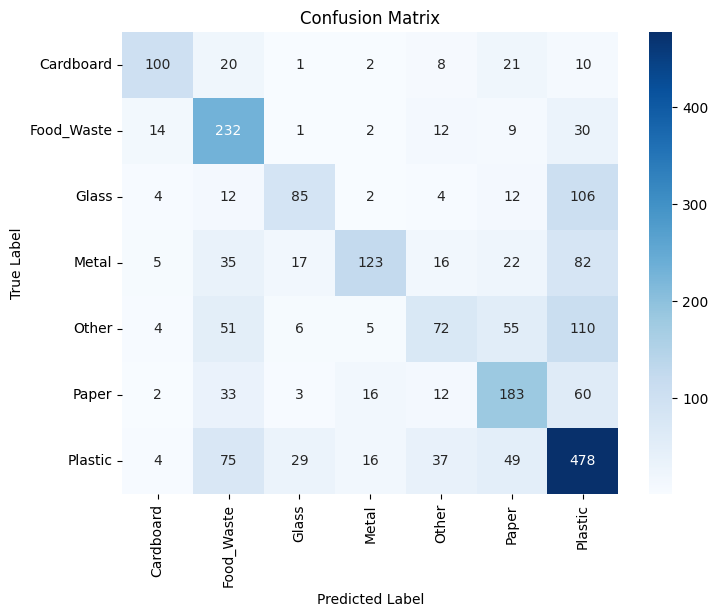

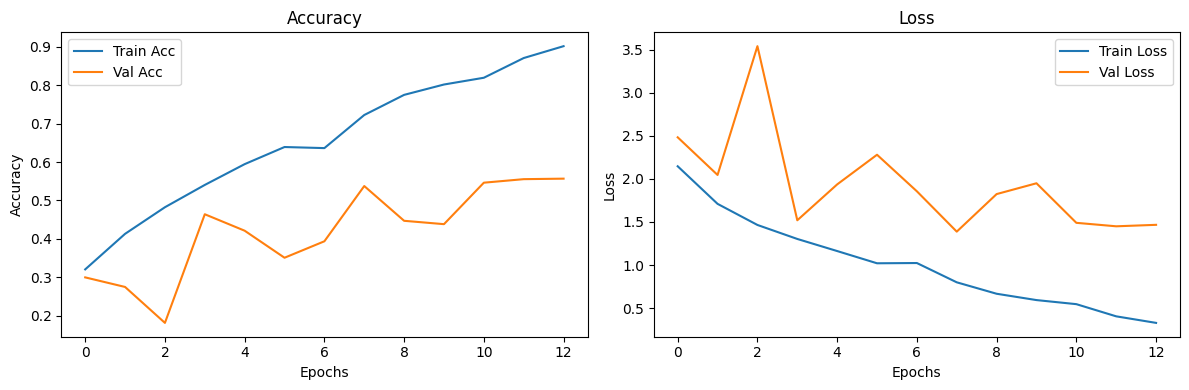

In [ ]:
############################# MODEL Number 1 ####################################

# Evaluate on the test set; display suitable metrics

# Load best model saved during training
best_model = load_model('best_model.h5')

# Evaluate on validation data
val_loss, val_accuracy = best_model.evaluate(val_generator, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions
y_pred_probs = best_model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.87      0.90      0.88       124
  Food_Waste       0.91      0.87      0.89       181
       Glass       0.93      0.84      0.88       148
       Metal       0.90      0.91      0.90       188
       Other       0.84      0.79      0.82       196
       Paper       0.82      0.79      0.80       216
     Plastic       0.85      0.91      0.88       472

    accuracy                           0.87      1525
   macro avg       0.87      0.86      0.87      1525
weighted avg       0.87      0.87      0.87      1525



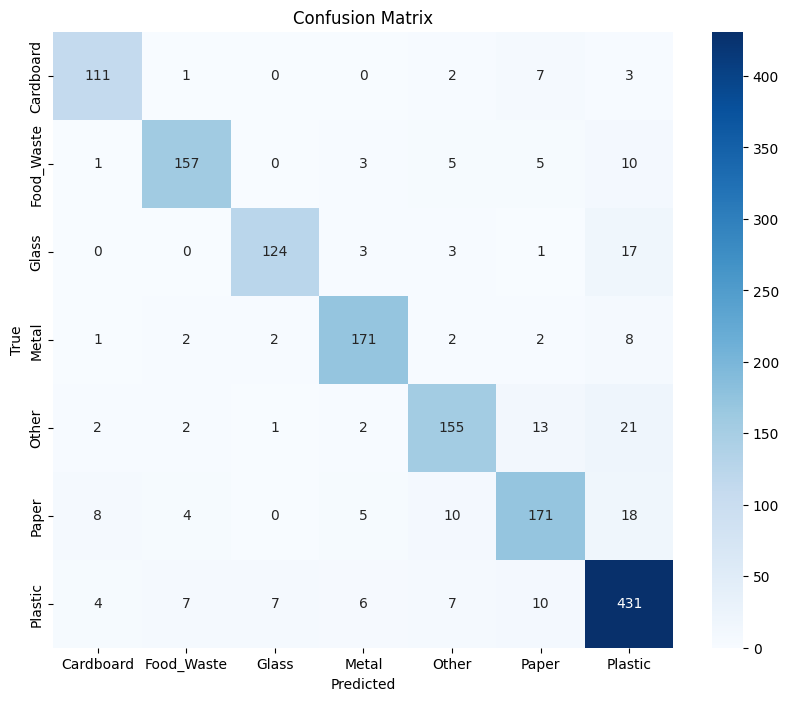

In [7]:
####################################  MODEL Number 2 #####################################

#################################### ResNet 18  ###########################################

# Get predictions and labels from validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Class labels
class_names = full_dataset.classes

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

#  Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

############# MODEL Number 1 ########################

The confusion matrix shows how the model performs across all classes:

**Best Performing Classes:**

Food_Waste: 232 correct predictions (relatively few misclassifications)

Plastic: 478 correct predictions (though with many misclassifications into other categories)


**Problematic Classes:**

Glass: Only 85 correct predictions with 106 misclassified as Plastic (major confusion)

Metal: 123 correct but significant misclassifications as Plastic (82)

Other: Only 72 correct with many misclassified as Plastic (110)

Paper: 183 correct but notable misclassifications as Plastic (60)


**Common Misclassification Pattern:**

Many classes are frequently misclassified as "Plastic", suggesting the model may be biased toward this category or that plastic waste shares visual features with other waste types.


**Accuracy Metrics**

The model achieved a training accuracy of 0.9 (90%), which appears good at first glance.

However, the confusion matrix reveals significant class imbalance issues and poor performance on several categories despite the high overall accuracy.


**Key Findings**

Class Imbalance Issues:

The number of correct predictions varies greatly (from 72 for "Other" to 478 for "Plastic"), suggesting uneven class representation in the dataset.

**Model Biases:**

The model shows a strong tendency to classify ambiguous cases as "Plastic", which could indicate either:
Plastic waste is overrepresented in training data
Plastic waste shares visual features with other categories
The model hasn't learned distinctive enough features for other classes

**Particular Challenges:**

Glass waste seems particularly difficult to classify correctly (only 85 correct vs 106 as Plastic)
The "Other" category performs poorly, which is expected but may need better definitio

**Recommendations for Improvement**

Data-Level Improvements:

Balance the dataset across all categories
Review labeling consistency, especially for problematic classes
Consider merging or redefining categories that are consistently confused (e.g., Glass and Plastic)

Model-Level Improvements:

Implement class weighting to handle imbalance
Try different architectures or add attention mechanisms
Apply more aggressive data augmentation for minority classes

###################################  MODEL Number 2 #####################################

#################################### ResNet 18  ###########################################

** Accuracy: 87%**

This is the overall correct prediction rate on the validation set.

**Strongest Classes:**

Metal: - Excellent on both precision (0.90) and recall (0.91).
Glass: - High precision (0.93), though slightly lower recall (0.84).
Plastic: - Good recall (0.91) — important since it has the most support (472 samples).

**Slightly Weaker Classes:**

Paper and Other have the lowest recall (~0.79) — the model misses some true cases here.
Other and Cardboard are also slightly confused with each other in the confusion matrix.


**Macro & Weighted Averages:**

Macro Avg F1 = 0.87 → Equal weight to each class — suggests balanced performance.

Weighted Avg F1 = 0.87 → Also good, means model handles dominant classes (like Plastic) well.

**Conclusions**

ResNet-18 model is performing very well with an overall 87% accuracy and strong per-class F1 scores.
It's suitable for deployment in most practical waste classification setups, with scope for minor
improvement via tuning or data enhancements.